# Coverage statistics / plots of selected sequences

In [1]:
%run "Header.ipynb"
import pileup
seq2pos2pileup = pileup.load()

### Real quick: what are the average coverages of each sequence?

In [2]:
seq2meancov = {}
for seq in SEQS:
    covs = []
    for pos in range(1, seq2len[seq] + 1):
        covs.append(pileup.get_cov(seq2pos2pileup[seq][pos]))
    mean_cov = mean(covs)
    median_cov = median(covs)
    print(f"Sequence {seq} has average coverage {mean_cov:,.2f} and median coverage {median_cov:,.2f}.")
    seq2meancov[seq] = mean_cov

Sequence edge_6104 has average coverage 4,158.57 and median coverage 4,122.00.
Sequence edge_1671 has average coverage 1,415.07 and median coverage 1,436.00.
Sequence edge_2358 has average coverage 2,993.46 and median coverage 2,936.00.


### Plot coverages across genomes

In [3]:
def show_coverage_plot(seq, axes, binlen=None, verbose=False):
    """seq should be an entry in SEQS. binlen can be None (if every position should be plotted),
    or it can be an integer -- in which case this will bin this many positions and just plot
    the average coverage within each bin (bins are not guaranteed to correspond to a uniform number
    of positions in the sequence unless the length of the sequence is exactly divisible by binlen).
    """ 
    positions = range(1, seq2len[seq] + 1)
    coverages = [pileup.get_cov(seq2pos2pileup[seq][pos]) for pos in positions]
    
    title = f"{seq2name[seq]}: mean coverage {round(seq2meancov[seq]):,}x"
    
    if binlen is None:
        axes.scatter(positions, coverages, c=SCATTERPLOT_PT_COLOR)
    else:
        seqlen = len(positions)
        if verbose: print("Doing binning. Seq len for {} is {}".format(seq, seqlen))
        if binlen < 1 or binlen > seqlen:
            # A bin length of 1 shouldn't change anything, compared with binlen=None (since at that
            # point each bin maps one-to-one to a position); a bin length equal to the sequence length
            # just transforms this into plotting a single point with the average coverage across the
            # whole sequence. Anything below or above either of these makes no sense.
            raise ValueError("binlen is outside of [1, seq length].")
        binned_positions = []
        binned_coverages = []
        left_pos = 1
        while left_pos + binlen - 1 <= seqlen:
            # The -1 is needed to fit things in properly.
            # For example, say our sequence is ABCDEFGHIJKLMNOP (start = 1, end = 16).
            # Bins w/ length 3:                1234567890123456
            #                                  ---===---===---=
            # The [left pos, right pos] intervals are:
            # [1, 3], [4, 6], [7, 9], [10, 12], [13, 15], [16]
            right_pos = left_pos + binlen - 1
            binned_positions.append((left_pos + right_pos) / 2)
            positions = range(left_pos, right_pos + 1)
            mean_cov = mean([coverages[p - 1] for p in positions])
            if mean_cov > 8000:
                print("Bin with average coverage > 8 kbp in {} from [{}, {}]".format(
                    seq2name[seq], left_pos, right_pos
                ))
                if mean_cov > 40000:
                    print("ALSO THIS SAME BIN HAS AVERAGE COVERAGE > 40 kbp: cov is {:,}".format(mean_cov))
            binned_coverages.append(mean_cov)
            if verbose: print("Created bin for [{}, {}]".format(left_pos, right_pos))
            left_pos = right_pos + 1

        # Unless seqlen was evenly divisible by binlen, there will be some extra positions not
        # in any bins yet (at the right end of the sequence). Create a new bin to hold these.
        if left_pos <= seqlen:
            positions = range(left_pos, seqlen + 1)
            binned_positions.append((positions[0] + positions[-1]) / 2)
            mean_cov = mean([coverages[p - 1] for p in positions])
            binned_coverages.append(mean_cov)
            if verbose: print("Created extra bin for [{}, {}]".format(positions[0], positions[-1]))
            title += "\nEvery dot but the rightmost represents a bin of {:,} bp.".format(binlen)
            title += " The rightmost dot is a bin of {:,} bp.".format(len(positions))
        else:
            title += "\nEvery dot represents a bin of {:,} bp.".format(binlen)

        axes.scatter(binned_positions, binned_coverages, c=SCATTERPLOT_PT_COLOR)
    
    axes.axhline(y=seq2meancov[seq], linestyle="--", color="#000000")
    
    # yanked from the mutation hot/coldspot viz ntbk: show ticks starting at 1 and then going up through every
    # 200 kbp
    xticks = [1]
    
    # Use less ticks for longer sequences. These actually work out to roughly dx = (sequence length) / 7
    if seq == "edge_2358":
        dx = 400000
    elif seq == "edge_1671":
        dx = 300000
    else:
        dx = 200000
        
    curr_x_pos = dx
    while curr_x_pos <= seq2len[seq]:
        xticks.append(curr_x_pos)
        curr_x_pos += dx
    axes.set_xticks(xticks)
    # apparently the above code snippet for setting the ticks is incompatible with use_thousands_sep(). OH WELL
    axes.xaxis.set_major_formatter("{x:,.0f}")
    
    use_thousands_sep(axes.get_yaxis())
    
    axes.set_title(title)
    axes.set_xlabel("Sequence position (bp)")
    if binlen is None:
        axes.set_ylabel("Coverage")
    else:
        axes.set_ylabel("Mean coverage within each bin")
    
    # Add a bit of padding to the left and right sides of the plot so we can comfortably see everything.
    # This padding should be proportional to the sequence length, so it doesn't look uneven between plots.
    xpad = 0.02 * seq2len[seq] 
    axes.set_xlim(-xpad, seq2len[seq] + xpad)
    axes.set_ylim(0)

#### Coverages: no binning, one dot per position

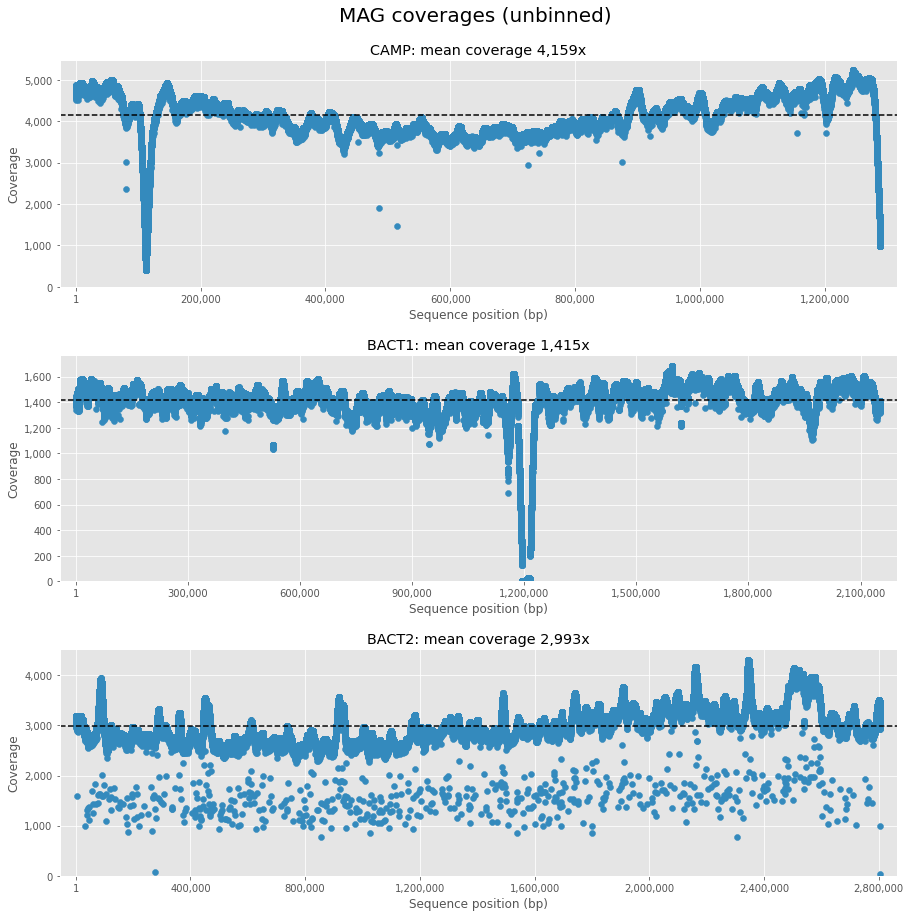

In [4]:
figN, (ax1N, ax2N, ax3N) = pyplot.subplots(3, gridspec_kw={"hspace": 0.3})
show_coverage_plot("edge_6104", ax1N)
show_coverage_plot("edge_1671", ax2N)
show_coverage_plot("edge_2358", ax3N)
figN.set_size_inches(15, 15)
figN.suptitle("MAG coverages (unbinned)", y=0.93, x=0.51, fontsize=20)
# Remove gratuitous whitespace in saved image: https://stackoverflow.com/a/11847260
figN.savefig("figs/seq-coverage-unbinned.png", bbox_inches="tight")

#### Coverages: with binning every 1 kbp
Subplot stuff based on [the matplotlib docs](https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/subplots_demo.html) and [this Stack Overflow comment](https://stackoverflow.com/a/35881382) (from which I learned about `gridspec_kw`).

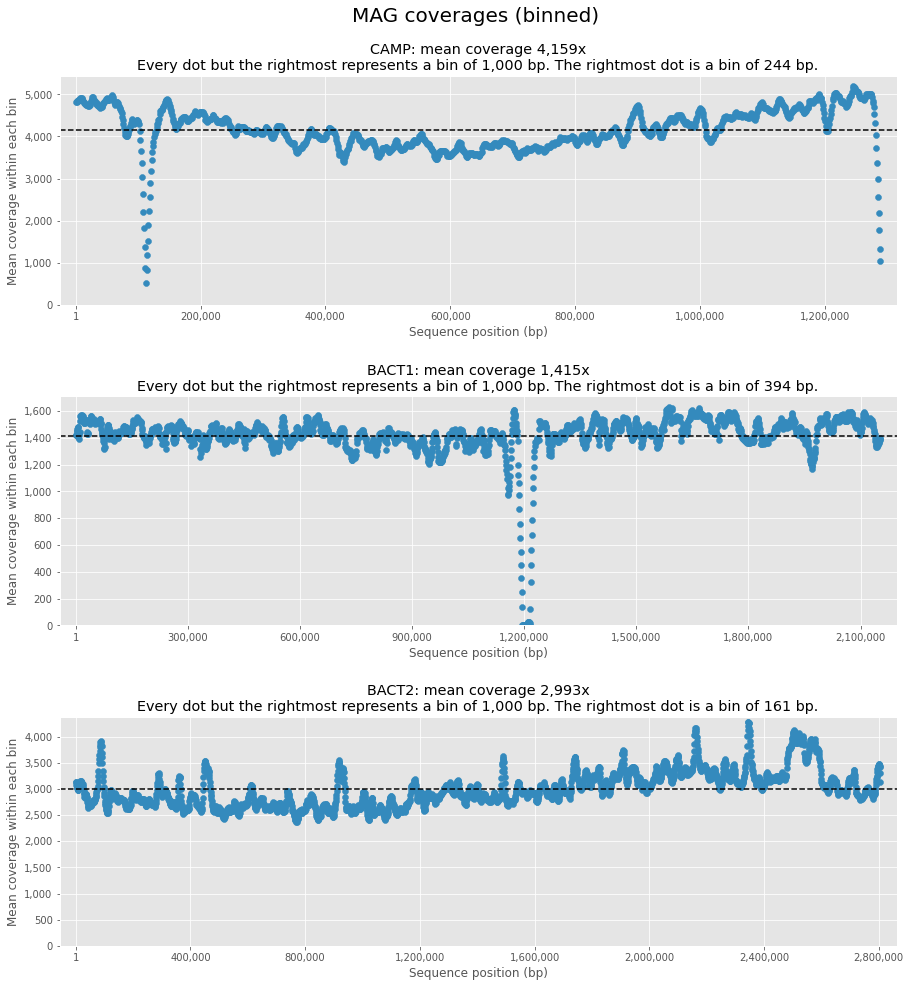

In [5]:
fig, (ax1, ax2, ax3) = pyplot.subplots(3, gridspec_kw={"hspace": 0.4})
show_coverage_plot("edge_6104", ax1, binlen=1000)
show_coverage_plot("edge_1671", ax2, binlen=1000)
show_coverage_plot("edge_2358", ax3, binlen=1000)
# Allocate a bit more vertical space, because the titles now each have two rows 
fig.set_size_inches(15, 16)
fig.suptitle("MAG coverages (binned)", y=0.94, x=0.51, fontsize=20)
# Remove gratuitous whitespace in saved image: https://stackoverflow.com/a/11847260
fig.savefig("figs/seq-coverage-binned.png", bbox_inches="tight")